### Vehicle Detection & Tracking

#### Load Modules

In [1]:
# LOAD MODULES
# Import Modules
import pickle
import os
import pickle
import math
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
import glob
import time
from sklearn.utils import shuffle
import csv
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage as ndi
from skimage.feature import blob_doh
from skimage.feature import peak_local_max
from skimage.morphology import watershed,disk
from skimage.filters import rank
from skimage.filters import gaussian_filter
from skimage.util import img_as_ubyte
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

print('Importing Modules')

Importing Modules


#### Load Data

In [2]:
# LOAD DATA
# Initialize Image Arrays for Vehicles & Non-Vehicles
Cars=[]
NotCars=[]

# Load Vehicles Image Directory
os.chdir('..')
OS=str(os.getcwd())
CarsPath=OS+'/Data/Vehicles/*'

# Load Vehicles Images
CarsImages=glob.glob(CarsPath)
for FolderNum in CarsImages:
        Cars+= glob.glob('{}/*.png'.format(FolderNum))

# Load Non-Vehicles Image Directory
NotCarsPath=OS+'/Data/Non-Vehicles/*'

# Load Vehicles Images
NotCarsImages=glob.glob(NotCarsPath)
for FolderNum in NotCarsImages:
        NotCars+= glob.glob('{}/*.png'.format(FolderNum))
        
print('Importing Data')

Importing Data


#### Dataset Summary & Exploration

In [3]:
# DATASET SUMMARY
# Define a Function to return some characteristics of the Dataset 
def DataLook(CarList,NotCarList):
    # Initliaze
    DataDict={}
    
    # Define a Key in DataDict "NumCars" and store the Number of Car Images
    DataDict["NumCars"]=len(CarList)

    # Define a Key in DataDict "NumNotCars" and store the Number of Non-Car Images
    DataDict["NumNotCars"]=len(NotCarList)
    
    # Read in a Test Car Image
    ExampleImgCar=mpimg.imread(CarList[0])
    
    # Define a Key "ImageShape" and store the Test Image Shape 3-Tuple
    DataDict["ImageShape"]=ExampleImgCar.shape
    
    # Define a key "DataType" and store the Data Type of the Test Image.
    DataDict["DataType"] = ExampleImgCar.dtype
    
    # Return DataDict
    return DataDict

Your function returned a count of 8792  Cars and 8968  Non-Cars
of Size:  (64, 64, 3)  and Data Type: float32


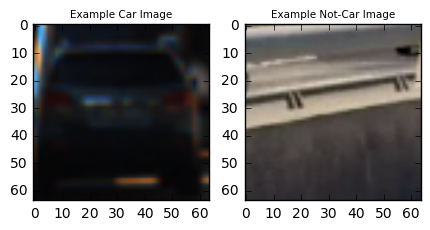

In [4]:
# DATASET SUMMARY
# Read Dataset Characteristics
DataInfo=DataLook(Cars,NotCars)

# Print Dataset Characteristics
print('Your function returned a count of', 
      DataInfo["NumCars"], ' Cars and', 
      DataInfo["NumNotCars"], ' Non-Cars')
print('of Size: ',DataInfo["ImageShape"], ' and Data Type:', 
      DataInfo["DataType"])

# Choose Random Car & Non-car Indices and Plot Example Images   
CarIndex=np.random.randint(0,len(Cars))
NotCarIndex=np.random.randint(0,len(NotCars))
    
# Read in Car & Non-Car Images
CarImage=mpimg.imread(Cars[CarIndex])
NotCarImage=mpimg.imread(NotCars[NotCarIndex])

# Plot the Examples
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(5,5))
Axis1.imshow(CarImage)
Axis1.set_title('Example Car Image',fontsize=7.5)
Axis2.imshow(NotCarImage)
Axis2.set_title('Example Not-Car Image',fontsize=7.5)

#### Convert Color Space

In [5]:
# CONVERT COLOR SPACE
def ConvertColorSpace(Img,ColorSpace='RGB'):
    if ColorSpace!='RGB':
        if ColorSpace=='HSV':
            FeatureImage=cv2.cvtColor(Img,cv2.COLOR_RGB2HSV)
        elif ColorSpace=='LUV':
            FeatureImage=cv2.cvtColor(Img,cv2.COLOR_RGB2LUV)
        elif ColorSpace=='HLS':
            FeatureImage=cv2.cvtColor(Img,cv2.COLOR_RGB2HLS)
        elif ColorSpace == 'YUV':
            FeatureImage=cv2.cvtColor(Img,cv2.COLOR_RGB2YUV)
        elif ColorSpace=='YCrCb':
            FeatureImage=cv2.cvtColor(Img,cv2.COLOR_RGB2YCrCb)
    else: FeatureImage=np.copy(Img)
    
    # Return Image 
    return FeatureImage     

print('Function for Converting Color Space')

Function for Converting Color Space


#### HoG Features 

In [6]:
# HOG FEATURES
def GetHoGFeatures(Img,Orient,PixPerCell,CellPerBlock,Vis=False,FeatureVec=True):
    # Use skimage.hog() to get Features and a Visualization
    if Vis == True:
        Features,HoGImage=hog(Img,
                              orientations=Orient,
                              pixels_per_cell=(PixPerCell,PixPerCell),
                              cells_per_block=(CellPerBlock,CellPerBlock),
                              transform_sqrt=True,
                              visualise=Vis,
                              feature_vector=FeatureVec)
       
        # Return Features and Visualization
        return Features,HoGImage
    
    # Use skimage.hog() to get Features only
    else:  
        Features=hog(Img,
                     orientations=Orient,
                     pixels_per_cell=(PixPerCell,PixPerCell),
                     cells_per_block=(CellPerBlock,CellPerBlock),
                     transform_sqrt=True,
                     visualise=Vis,
                     feature_vector=FeatureVec)
        
        # Return Features
        return Features
    
print('Function for Histogram of Gradient Features')

Function for Histogram of Gradient Features


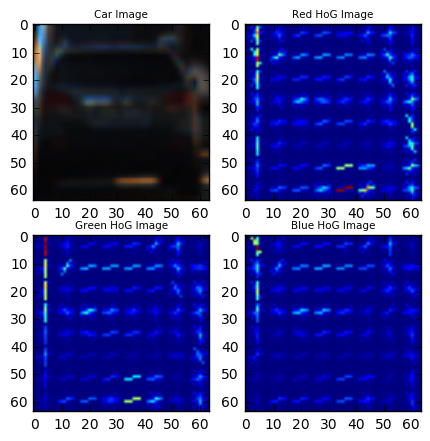

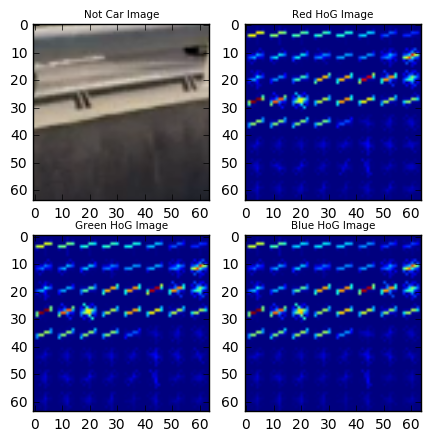

In [7]:
# HOG FEATURES
# Compute HoG Features for Sample Vehicle Image
RHoGFeaturesCarImage,RHoGCarImage=GetHoGFeatures(CarImage[:,:,0],9,8,2,Vis=True,FeatureVec=True)
GHoGFeaturesCarImage,GHoGCarImage=GetHoGFeatures(CarImage[:,:,1],9,8,2,Vis=True,FeatureVec=True)
BHoGFeaturesCarImage,BHoGCarImage=GetHoGFeatures(CarImage[:,:,2],9,8,2,Vis=True,FeatureVec=True)

# Plot HoG Image
Fig,((Axis1,Axis2),(Axis3,Axis4))=plt.subplots(2,2,figsize=(5,5))
Axis1.imshow(CarImage)
Axis1.set_title('Car Image',fontsize=7.5)
Axis2.imshow(RHoGCarImage)
Axis2.set_title('Red HoG Image',fontsize=7.5)
Axis3.imshow(GHoGCarImage)
Axis3.set_title('Green HoG Image',fontsize=7.5)
Axis4.imshow(BHoGCarImage)
Axis4.set_title('Blue HoG Image',fontsize=7.5)

# Compute HoG Features for Sample Non-Vehicle Image
RHoGFeaturesNotCarImage,RHoGNotCarImage=GetHoGFeatures(NotCarImage[:,:,0],9,8,2,Vis=True,FeatureVec=True)
GHoGFeaturesNotCarImage,GHoGNotCarImage=GetHoGFeatures(NotCarImage[:,:,1],9,8,2,Vis=True,FeatureVec=True)
BHoGFeaturesNotCarImage,BHoGNotCarImage=GetHoGFeatures(NotCarImage[:,:,2],9,8,2,Vis=True,FeatureVec=True)

# Plot HoG Image
Fig2,((Axis5,Axis6),(Axis7,Axis8))=plt.subplots(2,2,figsize=(5,5))
Axis5.imshow(NotCarImage)
Axis5.set_title('Not Car Image',fontsize=7.5)
Axis6.imshow(RHoGNotCarImage)
Axis6.set_title('Red HoG Image',fontsize=7.5)
Axis7.imshow(GHoGNotCarImage)
Axis7.set_title('Green HoG Image',fontsize=7.5)
Axis8.imshow(BHoGNotCarImage)
Axis8.set_title('Blue HoG Image',fontsize=7.5)

#### Spatial Binning of Color

In [8]:
# BINNED COLOR FEATURES  
def BinSpatial(Img,Size=(32,32)): 
    # Use cv2.resize().ravel() to create the Feature Vector
    Features=cv2.resize(Img,Size).ravel() 
    
    # Return Features
    return Features

print('Function for Spatial Binning of Color')

Function for Spatial Binning of Color


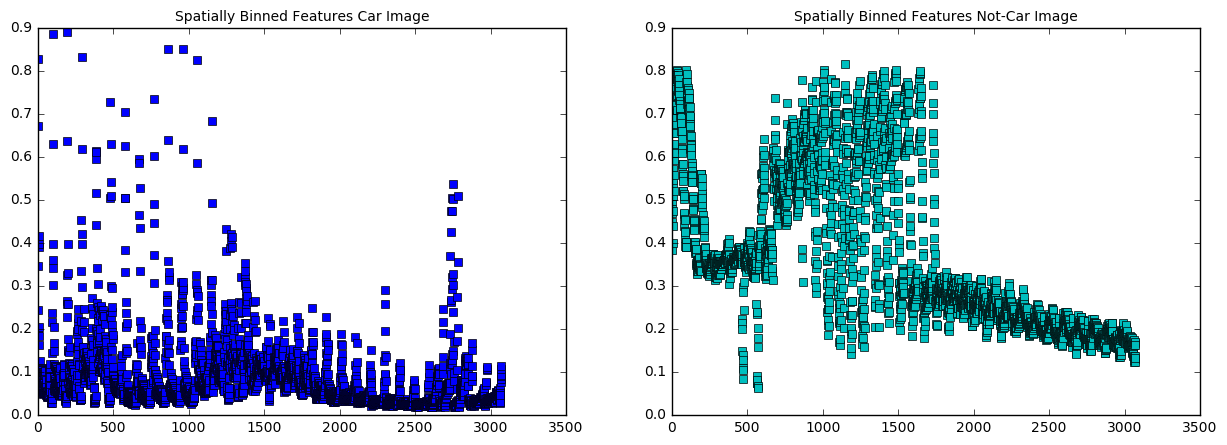

In [9]:
# BINNED COLOR FEATURES
# Compute Spatially Binned Features for Sample Vehicle Image
CarImage=ConvertColorSpace(CarImage,'RGB')
CarImageSpatialFeature=BinSpatial(CarImage,Size=(32,32))

# Compute Spatially Binned Features for Sample Non-Vehicle Image
NotCarImage=ConvertColorSpace(NotCarImage,'RGB')
NotCarImageSpatialFeature=BinSpatial(NotCarImage,Size=(32,32))

# Plot Features
Fig,(Axis1,Axis2)=plt.subplots(1,2,figsize=(15,5))
Axis1.plot(CarImageSpatialFeature,'bs')
Axis1.set_title('Spatially Binned Features Car Image',fontsize=10)
Axis2.plot(NotCarImageSpatialFeature,'cs')
Axis2.set_title('Spatially Binned Features Not-Car Image',fontsize=10)

#### Histogtam Features

In [10]:
# HISTOGRAM OF COLOR
def ColorHist(Img,NBins=32,BinsRange=(0,256)):
    # Compute the Histogram of the RGB Channels separately
    RHist=np.histogram(Img[:,:,0],bins=NBins,range=BinsRange)
    GHist=np.histogram(Img[:,:,1],bins=NBins,range=BinsRange)
    BHist=np.histogram(Img[:,:,2],bins=NBins,range=BinsRange)
    
    # Concatenate the Histograms into a Single Feature Vector
    HistFeatures=np.concatenate((RHist[0],GHist[0],BHist[0]))
    
    # Generating Bin Centers
    BinEdges=RHist[1]
    BinCenters=(BinEdges[1:]+BinEdges[0:len(BinEdges)-1])/2
    
    # Return the Individual Histograms, Bin Centers and Feature Vector
    return RHist,GHist,BHist,BinCenters,HistFeatures

print('Function for Histogram of Color')

Function for Histogram of Color


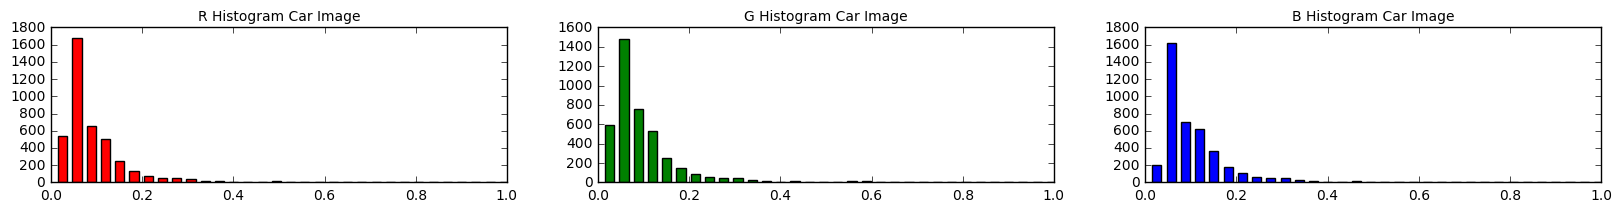

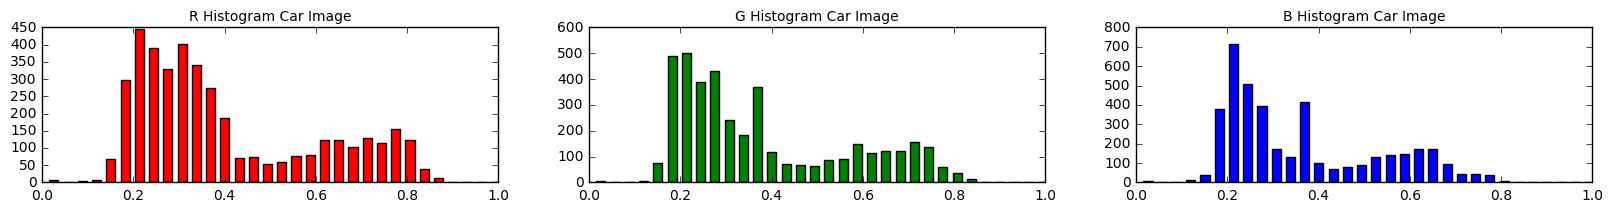

In [11]:
# HISTOGRAM OF COLOR
# Compute Color Histogram Features for Sample Vehicle Image
RHistCarImage,GHistCarImage,BHistCarImage,BinCentersCarImage,HistFeaturesCarImage=ColorHist(CarImage,
                                                                                            NBins=32,
                                                                                            BinsRange=(0,1))
                                                                                            
# Plot Features
Fig,(Axis1,Axis2,Axis3)=plt.subplots(1,3,figsize=(20,2))
Axis1.bar(BinCentersCarImage,RHistCarImage[0],width=0.02,color='Red')
Axis1.set_xlim(0,1)
Axis1.set_title('R Histogram Car Image',fontsize=10)
Axis2.bar(BinCentersCarImage,GHistCarImage[0],width=0.02,color='Green')
Axis2.set_xlim(0,1)
Axis2.set_title('G Histogram Car Image',fontsize=10)
Axis3.bar(BinCentersCarImage,BHistCarImage[0],width=0.02,color='Blue')
Axis3.set_xlim(0,1)
Axis3.set_title('B Histogram Car Image',fontsize=10)  

# Compute Color Histogram Features for Sample Non-Vehicle Image
RHistNotCarImage,GHistNotCarImage,BHistNotCarImage,BinCentersNotCarImage,HistFeaturesNotCarImage=\
                                                                                            ColorHist(NotCarImage,
                                                                                            NBins=32,
                                                                                            BinsRange=(0,1))
                                                                                            
# Plot Features
Fig2,(Axis4,Axis5,Axis6)=plt.subplots(1,3,figsize=(20,2))
Axis4.bar(BinCentersNotCarImage,RHistNotCarImage[0],width=0.02,color='Red')
Axis4.set_xlim(0,1)
Axis4.set_title('R Histogram Car Image',fontsize=10)
Axis5.bar(BinCentersNotCarImage,GHistNotCarImage[0],width=0.02,color='Green')
Axis5.set_xlim(0,1)
Axis5.set_title('G Histogram Car Image',fontsize=10)
Axis6.bar(BinCentersNotCarImage,BHistNotCarImage[0],width=0.02,color='Blue')
Axis6.set_xlim(0,1)
Axis6.set_title('B Histogram Car Image',fontsize=10)  

#### Feature Extraction

In [12]:
# FEATURE EXTRACTION
# Define a Function to Extract Features from a List of Images
# Have this Function call BinSpatial(), GetHoGFeatures() and ColorHist()
def ExtractFeaturesAll(Imgs,ColorSpace='RGB',SpatialSize=(32,32),HistBins=32,HistRange=(0,256),Orient=9,
                       PixPerCell=8,CellPerBlock=2,HoGChannel=0,
                       SpatialFeaturesFlag=True,ColorHistFeaturesFlag=True,HoGFeaturesFlag=True):
    # Create a List to append Feature Vectors to
    Features=[]
    
    # Iterate through the List of Images
    for File in Imgs:        
        # Create a List to append Feature Vectors to
        FileFeatures=[]
        
        # Read in Each Image
        Image=mpimg.imread(File)
        
        # Apply Color Conversion if other than RGB
        FeatureImage=ConvertColorSpace(Image,ColorSpace)
        
        # Check if SpatialFeaturesFlag is High
        if SpatialFeaturesFlag==True:
            # Apply BinSpatial() to get Spatial Color Features 
            SpatialFeatures=BinSpatial(FeatureImage,Size=SpatialSize)
            
            # Append the Spatial Filters
            FileFeatures.append(SpatialFeatures)
        
        # Check if ColorHistFeaturesFlag is High
        if ColorHistFeaturesFlag==True:
            # Apply ColorHist() also with a Color Space
            RHist,GHist,BHist,BinCenters,HistFeatures=ColorHist(FeatureImage,NBins=HistBins,BinsRange=HistRange)
        
            # Append the Hist Filters
            FileFeatures.append(HistFeatures)
        
        # Check if HoGFeaturesFlag is High
        if HoGFeaturesFlag==True:
            # Call GetHoGFeatures() with Vis=False, FeatureVec=True
            if HoGChannel=='ALL':
                
                # Create a List to append HoG Features
                HoGFeatures=[]
                for Channel in range(FeatureImage.shape[2]):
                    HoGFeatures.append(GetHoGFeatures(FeatureImage[:,:,Channel],
                                                      Orient,PixPerCell,CellPerBlock,
                                                      Vis=False,FeatureVec=True))
                HoGFeatures=np.ravel(HoGFeatures)        
            else:
                HoGFeatures=GetHoGFeatures(FeatureImage[:,:,HoGChannel],Orient,
                                           PixPerCell,CellPerBlock,
                                           Vis=False,FeatureVec=True)
                
            # Append the new Feature Vector to the File Features List
            FileFeatures.append(HoGFeatures)
        
        # Append the Feature Vector to the Features List 
        Features.append(np.concatenate(FileFeatures))

    # Return list of Feature Vectors
    return Features

print('Function for Extracting Features from Dataset')

Function for Extracting Features from Dataset


In [13]:
# FEATURE EXTRACTION
# Set Parameters
ColorSpace='YCrCb'
Orient=9
PixPerCell=8
CellPerBlock=2
HoGChannel=0 # Can be 0, 1, 2, or "ALL"
SpatialSize=(16,16)
HistBins=16
HistRange=(0,1)
SpatialFeaturesFlag=True
ColorHistFeaturesFlag=True
HoGFeaturesFlag=True

print('Setting Parameters')

Setting Parameters


In [14]:
# FEATURE EXTRACTION
# Extract Features for Car Images
CarFeatures=ExtractFeaturesAll(Cars,ColorSpace=ColorSpace,
                               SpatialSize=SpatialSize,
                               HistBins=HistBins,
                               HistRange=HistRange,
                               Orient=Orient,
                               PixPerCell=PixPerCell,
                               CellPerBlock=CellPerBlock,
                               HoGChannel=HoGChannel,
                               SpatialFeaturesFlag=SpatialFeaturesFlag,
                               ColorHistFeaturesFlag=ColorHistFeaturesFlag,
                               HoGFeaturesFlag=HoGFeaturesFlag)

# Extract Features for Non-Car Images
NotCarFeatures=ExtractFeaturesAll(NotCars,ColorSpace=ColorSpace,
                               SpatialSize=SpatialSize,
                               HistBins=HistBins,
                               HistRange=HistRange,
                               Orient=Orient,
                               PixPerCell=PixPerCell,
                               CellPerBlock=CellPerBlock,
                               HoGChannel=HoGChannel,
                               SpatialFeaturesFlag=SpatialFeaturesFlag,
                               ColorHistFeaturesFlag=ColorHistFeaturesFlag,
                               HoGFeaturesFlag=HoGFeaturesFlag)

print('Features for Car and Non-Car Images Extracted')

Features for Car and Non-Car Images Extracted


#### Setup Training & Test Data

In [17]:
# SETUP TRAINING & TEST DATA
# Create an Array Stack of Feature Vectors
X=np.vstack((CarFeatures,NotCarFeatures)).astype(np.float64)

# Fit a Per-Column Scaler
XScaler=StandardScaler().fit(X)

# Apply the Scaler to X
ScaledX=XScaler.transform(X)

# Define the Labels Vector
Y=np.hstack((np.ones(len(CarFeatures)),np.zeros(len(NotCarFeatures))))

In [18]:
# SETUP TRAINING & TEST DATA
# Split Data into Randomized Training and Test Sets
RandState=np.random.randint(0,100)
XTrain,XTest,YTrain,YTest=train_test_split(ScaledX,Y,test_size=0.2,random_state=RandState)

# Print the Number of Training & Test Data
print('Training Data:',len(YTrain))
print('Testing Data:',len(YTest))

Training Data: 14208
Testing Data: 3552


#### Train SVM Classifier

In [19]:
# TRAIN SVM CLASSIFIER
# Use a Linear SVC 
SVC=LinearSVC()

# Check the Training Time for the Start of SVC
Time01=time.time()

# Fit Classification Model
SVC.fit(XTrain,YTrain)

# Check the Training Time for the End of SVC
Time02=time.time()
print(round(Time02-Time01,2),'Seconds to train SVC...')

# Check the Score of the SVC
print('Test Accuracy of SVC:',round(SVC.score(XTest,YTest),4))

# Check the Prediction Time for a Single Sample
Time03=time.time()
NumPredict=10
print('Feature Vector Length:', len(XTrain[0]))
print('SVC Predicts: ',SVC.predict(XTest[0:NumPredict]))
print('For these',NumPredict, 'Labels: ',YTest[0:NumPredict])
Time04=time.time()
print(round(Time04-Time03,5),'Seconds to Predict',NumPredict,'Labels with SVC')

6.07 Seconds to train SVC...
Test Accuracy of SVC: 0.9721
Feature Vector Length: 2580
SVC Predicts:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
For these 10 Labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00107 Seconds to Predict 10 Labels with SVC


#### Feature Extraction

In [20]:
# FEATURE EXTRACTION
# Define a Function to Extract Features from Single Image
# Have this Function call BinSpatial(), GetHoGFeatures() and ColorHist()
def ExtractFeaturesImage(Img,ColorSpace='RGB',SpatialSize=(32,32),
                        HistBins=32,Orient=9,HistRange=(0,256),
                        PixPerCell=8,CellPerBlock=2,HoGChannel=0,
                        SpatialFeaturesFlag=True,ColorHistFeaturesFlag=True,HoGFeaturesFlag=True): 
    # Define an Empty List to Receive Features
    ImgFeatures=[]
    
    # Apply Color Conversion 
    FeatureImage=ConvertColorSpace(Img,ColorSpace)   

    # Check if SpatialFeaturesFlag is High
    if SpatialFeaturesFlag==True:
        # Apply BinSpatial() to get Spatial Color Features 
        SpatialFeatures=BinSpatial(FeatureImage,Size=SpatialSize)
            
        # Append the Spatial Filters
        ImgFeatures.append(SpatialFeatures)
                 
    # Check if ColorHistFeaturesFlag is High
    if ColorHistFeaturesFlag==True:
        # Apply ColorHist() also with a Color Space
        RHist,GHist,BHist,BinCenters,HistFeatures=ColorHist(FeatureImage,NBins=HistBins,BinsRange=HistRange)
        
        # Append the Hist Filters
        ImgFeatures.append(HistFeatures)    
        
        
    # Check if HoGFeaturesFlag is High
    if HoGFeaturesFlag==True:
        # Call GetHoGFeatures() with Vis=False, FeatureVec=True
        if HoGChannel=='ALL':
                
            # Create a List to append HoG Features
            HoGFeatures=[]
            for Channel in range(FeatureImage.shape[2]):
                HoGFeatures.extend(GetHoGFeatures(FeatureImage[:,:,Channel],
                                                  Orient,PixPerCell,CellPerBlock,
                                                  Vis=False,FeatureVec=True))       
          
        else:
            HoGFeatures=GetHoGFeatures(FeatureImage[:,:,HoGChannel],Orient,
                                       PixPerCell,CellPerBlock,
                                       Vis=False,FeatureVec=True)
            
            # Append the new Feature Vector to the File Features List
            ImgFeatures.append(HoGFeatures)

    # Return Concatenated Array of Features
    return np.concatenate(ImgFeatures)

#### Sliding Window Function

In [21]:
# WINDOW SLIDING FUNCTION
# Define a Function that takes an Image, Start and Stop Positions in both X and Y, 
# Window Size (X and Y Dimensions), and Overlap Fraction (for both X and Y)
def SlideWindows(Img,XStartStop=[None,None],YStartStop=[None,None], 
                    XYWindow=(64,64),XYOverlap=(0.5,0.5)):
    # If X and/or Y Start/Stop Positions not defined, Set to Image Size
    if XStartStop[0]==None:
        XStartStop[0]=0
    if XStartStop[1]==None:
        XStartStop[1]=Img.shape[1]
    if YStartStop[0]==None:
        YStartStop[0]=0
    if YStartStop[1]==None:
        YStartStop[1]=Img.shape[0]
        
    # Compute the Span of the Region to be searched    
    XSpan=XStartStop[1]-XStartStop[0]
    YSpan=YStartStop[1]-YStartStop[0]
    
    # Compute the Number of Pixels per Step in X/Y
    NxPixPerStep=np.int(XYWindow[0]*(1-XYOverlap[0]))
    NyPixPerStep=np.int(XYWindow[1]*(1-XYOverlap[1]))
    
    # Compute the Number of Windows in X/Y
    NxWindows=np.int(XSpan/NxPixPerStep)-1
    NyWindows=np.int(YSpan/NyPixPerStep)-1
    
    # Initialize a List to append Window Positions to
    WindowList=[]
    
    # Loop through finding X and Y Window Positions
    # Note: You could vectorize this step, but in practice
    # You'll be considering Windows One by One with the
    # Classifier, so Looping makes sense
    for Ys in range(NyWindows):
        for Xs in range(NxWindows):
            # Calculate window position
            StartX=Xs*NxPixPerStep+XStartStop[0]
            EndX=StartX+XYWindow[0]
            StartY=Ys*NyPixPerStep+YStartStop[0]
            EndY=StartY+XYWindow[1]
            
            # Append Window Position to List
            WindowList.append(((StartX,StartY),(EndX,EndY)))
            
    # Return the List of Windows
    return WindowList

#### Search Windows Function

In [22]:
# SEARCH WINDOWS FUNCTION
def SearchWindows(Img,Windows,ClassificationModel,Scaler,ColorSpace='RGB',
                  SpatialSize=(32,32),HistBins=32,
                  HistRange=(0,256),Orient=9,
                  PixPerCell=8,CellPerBlock=2,HoGChannel=0,
                  SpatialFeaturesFlag=True,ColorHistFeaturesFlag=True,HoGFeaturesFlag=True): 

    # Create an Empty List to Receive Positive Detection Windows
    OnWindows=[]
    
    # Iterate over All Windows in the List
    for Window in Windows:
        # Extract the Test Window from Original Image
        TestImg=cv2.resize(Img[Window[0][1]:Window[1][1],Window[0][0]:Window[1][0]],(64,64))  
        
        # Extract Features for the Window using ExtractFeaturesImage()       
        Features=ExtractFeaturesImage(TestImg,ColorSpace=ColorSpace,SpatialSize=SpatialSize,
                                      HistBins=HistBins,Orient=Orient,HistRange=(0,1),
                                      PixPerCell=PixPerCell,CellPerBlock=CellPerBlock,HoGChannel=HoGChannel,
                                      SpatialFeaturesFlag=True,
                                      ColorHistFeaturesFlag=True,
                                      HoGFeaturesFlag=True) 
        
        # Scale Extracted Features
        TestFeatures=Scaler.transform(np.array(Features).reshape(1,-1))
        
        # Predict using SVC Classifier
        Prediction=ClassificationModel.predict(TestFeatures)
        
        # If Positive (Prediction==1) then Save the Window
        if Prediction==1:
            OnWindows.append(Window)
            
    # Return Windows with Positive Detections
    return OnWindows

#### Miscellaneous Functions

In [23]:
# MISCELLANEOUS FUNCTIONS
# Define a Function for Plot Bounding Boxes
def DrawBoxes(Img,BBoxes,Color=(0,0,255),Thick=6):
    # Make a Copy of Image
    ImgCopy=np.copy(Img)

    # Iterate through the Bounding Boxes
    for BBox in BBoxes:
        # Draw a Rectangle given BBox Coordinates
        cv2.rectangle(ImgCopy,BBox[0],BBox[1],Color,Thick)

    # Return the Image
    return ImgCopy

In [24]:
# MISCELLANEOUS FUNCTIONS
# Define a Function to Assist in Heatmap
def AddHeat(Heat,BBoxList):
    # Iterate through list of bboxes
    for Box in BBoxList:
        # Add += 1 for All Pixels inside Each Box
        Heat[Box[0][1]:Box[1][1],Box[0][0]:Box[1][0]]+=1
        
    # Return Heatmap
    return Heat

In [25]:
# MISCELLANEOUS FUNCTIONS
# Define a Function to Assist in Heatmap
def ApplyThreshold(Heatmap,Threshold):
    # Zero out Pixels Less than the Threshold
    Heatmap[Heatmap<=Threshold]=0
    
    # Return Thresholded Heatmap
    return Heatmap

In [27]:
# MISCELLANEOUS FUNCTIONS
# Define a Function for Sanity Check
def SanityCheck(NonzeroX,NonzeroY):
    # Check Size
    if ((np.max(NonzeroX)-np.min(NonzeroX))>64 and (np.max(NonzeroY)-np.min(NonzeroY))>64):
        Flag=1
    else: 
        Flag=0
    
    # Return Flag
    return Flag

In [28]:
# MISCELLANEOUS FUNCTIONS
# Define a Function to Assist in Heatmap
def DrawLabeledBBoxes(Img,Labels):
    # Iterate through All Detected Cars
    for CarNumber in range(1,Labels[1]+1):
        # Find Pixels with Each CarNumber Label Value
        Nonzero=(Labels[0]==CarNumber).nonzero()
        
        # Identify X and Y values of those Pixels
        NonzeroY=np.array(Nonzero[0])
        NonzeroX=np.array(Nonzero[1])
        
        # Check if Sanity Check is Satisfied
        Flag=SanityCheck(NonzeroX,NonzeroY)
        
        if Flag==1:
            # Define a Bounding Box based on Min/Max X and Y
            BBox=((np.min(NonzeroX),np.min(NonzeroY)),(np.max(NonzeroX),np.max(NonzeroY)))
        
            # Draw the Box on the Image
            cv2.rectangle(Img,BBox[0],BBox[1],(0,1,0),10)
        
    # Return the Image
    return Img

#### Car Detection for Images

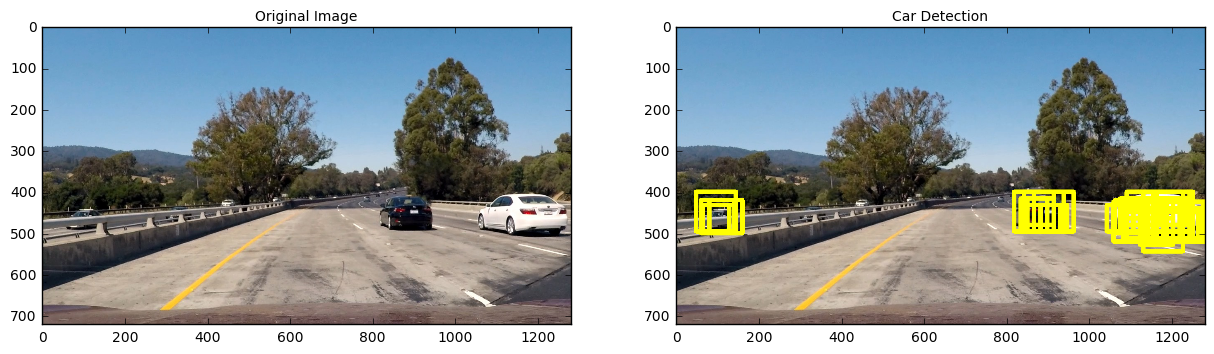

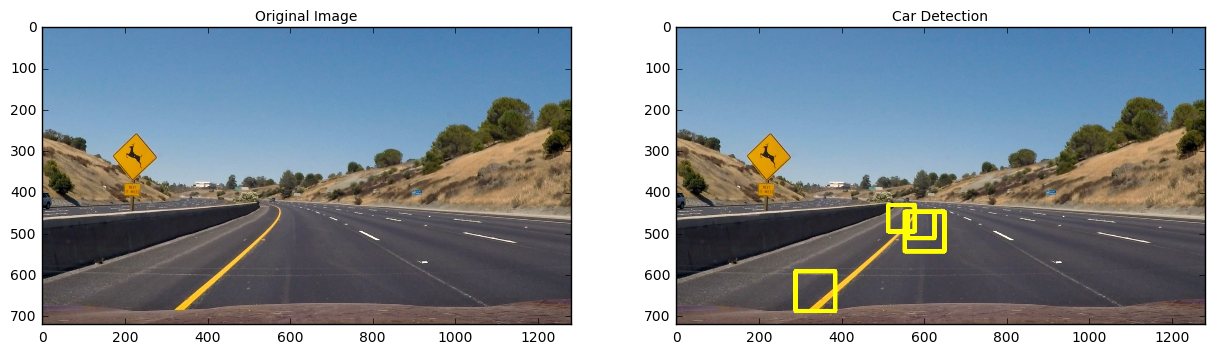

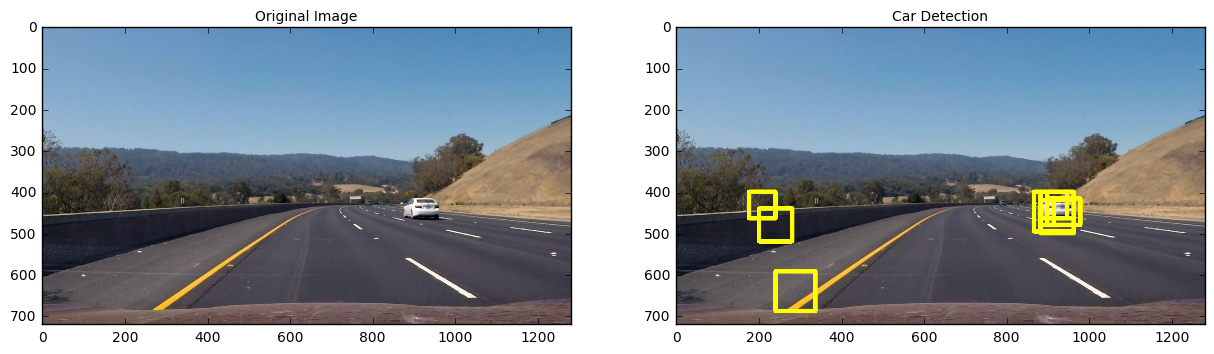

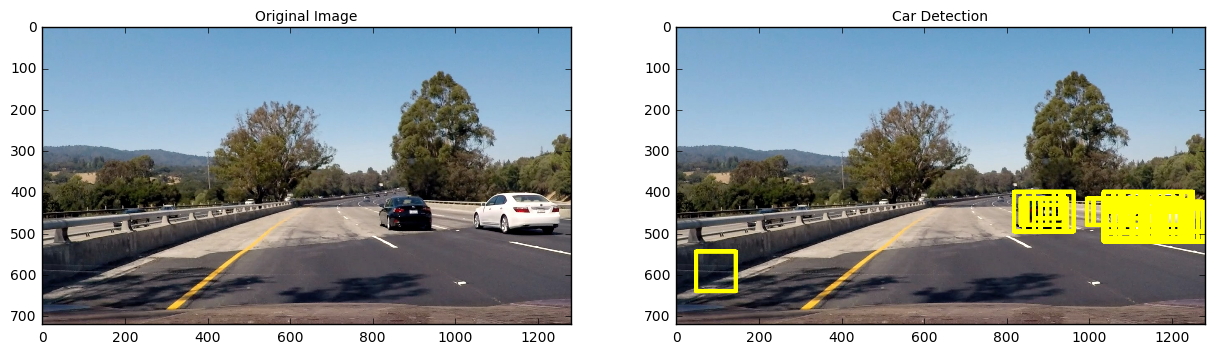

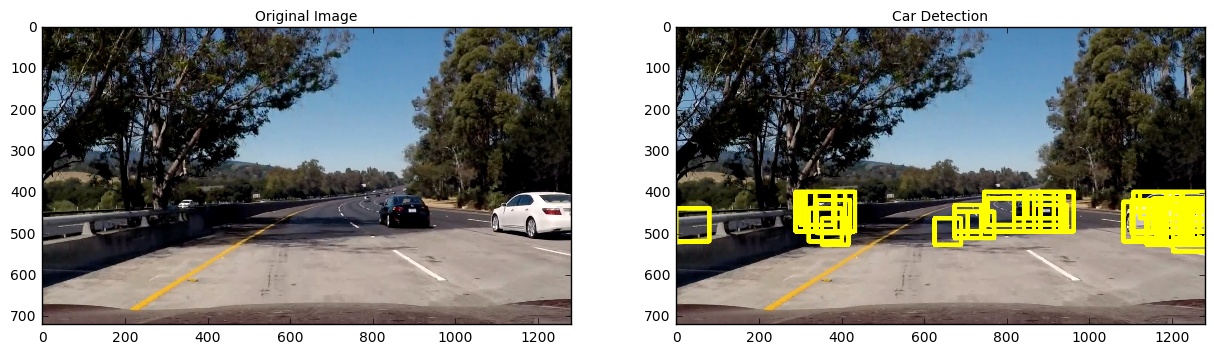

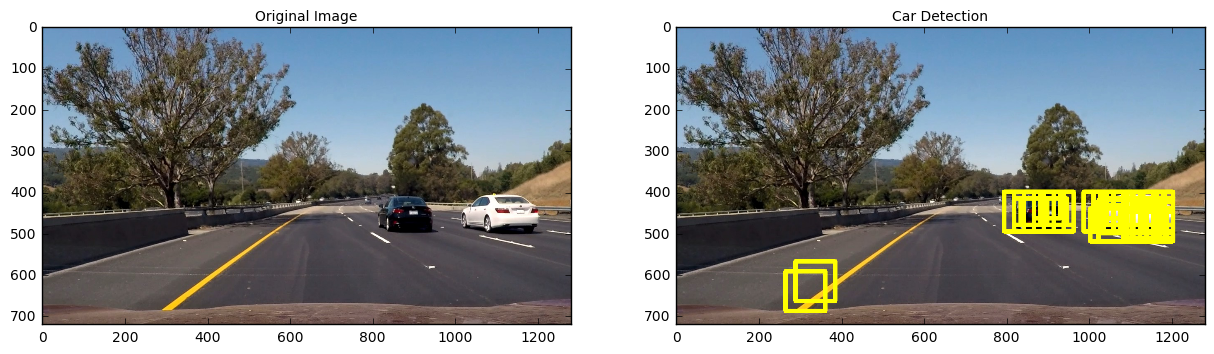

In [29]:
# SEARCH & CLASSIFY IMAGES
# Load Test Images
for i in range(1,7):
    # Load Image
    Filename='Test-Images/test{}.jpg'.format(i)
    Image=mpimg.imread(Filename)
    
    # Normalize Image
    Image=Image.astype(np.float32)/255
  
    # Set Multi-Scale Sliding Windows
    Windows=SlideWindows(Image,XStartStop=[None,None],YStartStop=[400,650], 
                    XYWindow=(96,96),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[0,400],YStartStop=[400,500], 
                    XYWindow=(80,80),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[880,1280],YStartStop=[400,500], 
                    XYWindow=(80,80),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[None,None],YStartStop=[400,500], 
                    XYWindow=(64,64),XYOverlap=(0.75,0.75))
    
    # Search Windows for Car Detection
    HotWindows=SearchWindows(Image,Windows,SVC,XScaler,ColorSpace='YCrCb',
                  SpatialSize=(16,16),HistBins=16,
                  HistRange=(0,1),Orient=Orient,
                  PixPerCell=8,CellPerBlock=2,HoGChannel=HoGChannel,
                  SpatialFeaturesFlag=True,ColorHistFeaturesFlag=True,HoGFeaturesFlag=True)
    
    # Draw Boxes 
    WindowImg=DrawBoxes(Image,HotWindows,Color=(1,1,0),Thick=10)                    
    
    # Plot
    Figure,(Axis1,Axis2)=plt.subplots(1,2,figsize=(15,15))
    Axis1.imshow(Image)
    Axis1.set_title('Original Image',fontsize=10)
    Axis2.imshow(WindowImg)
    Axis2.set_title('Car Detection',fontsize=10)
    
    # Scale Image
    WindowImg=WindowImg.astype(np.float32)*255
    
    # Save Images
    cv2.imwrite('Output-Images/Output{}.jpg'.format(i),WindowImg)

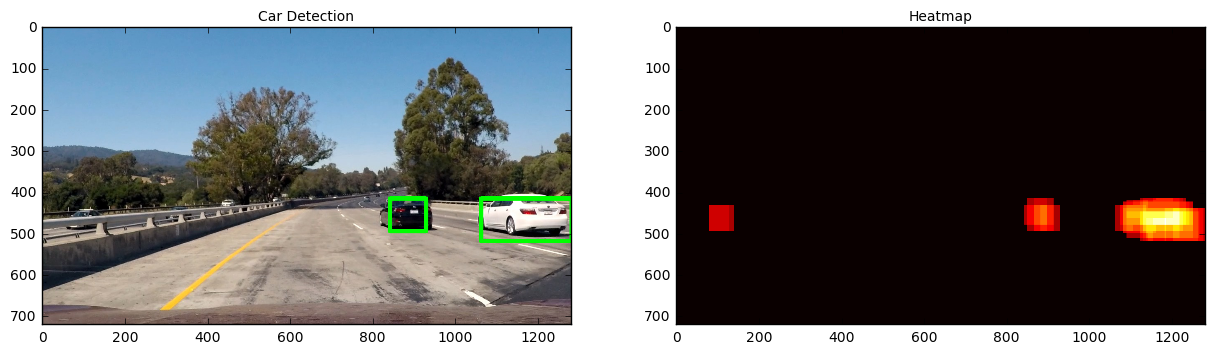

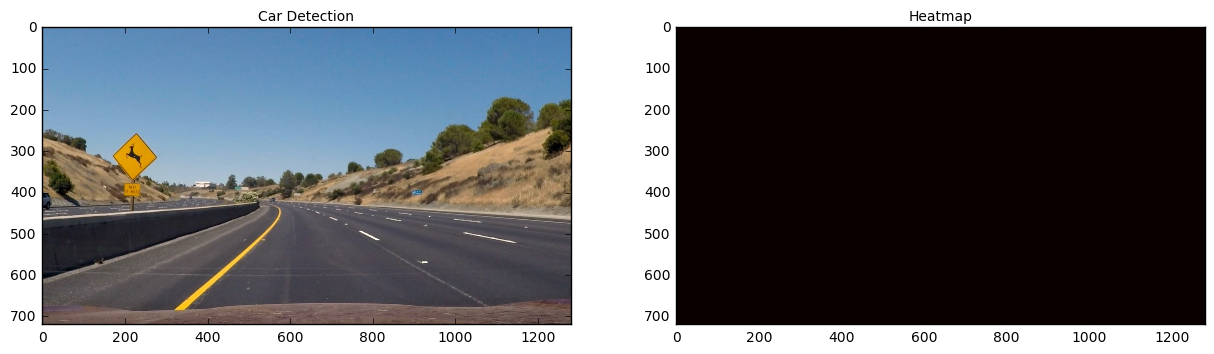

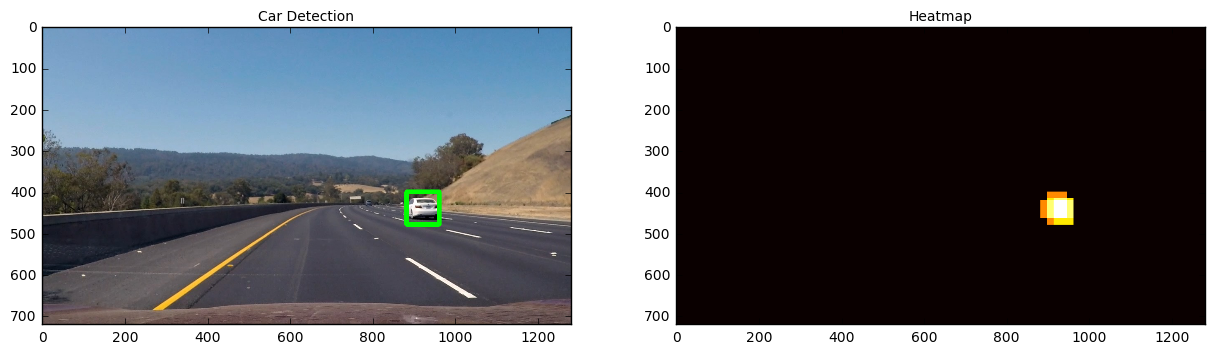

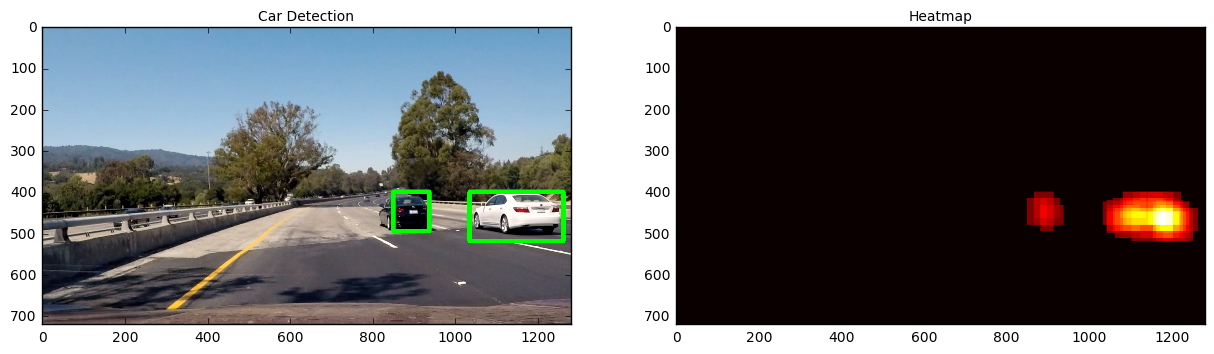

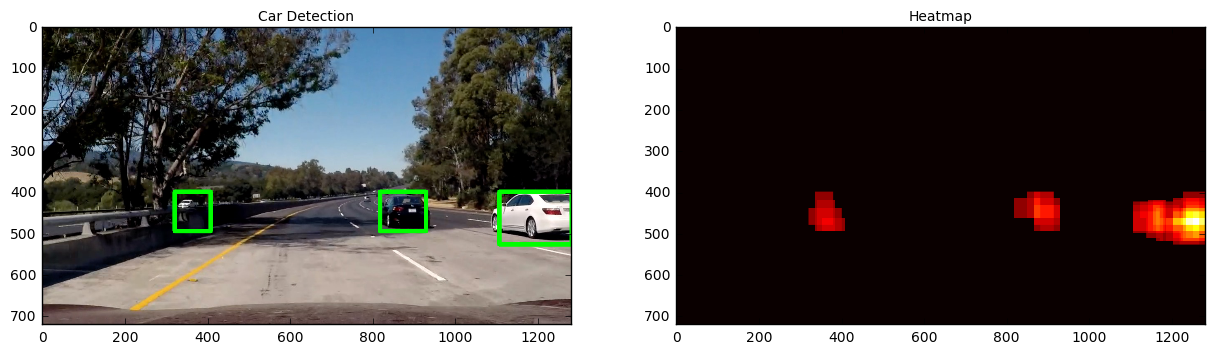

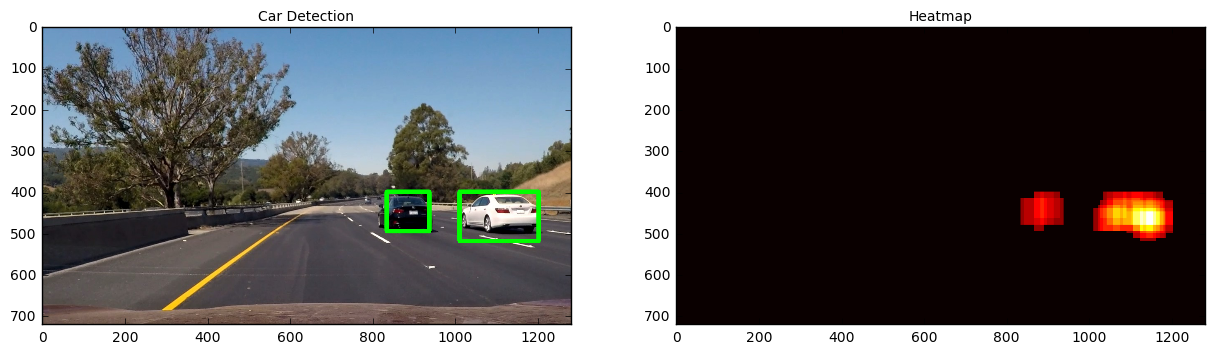

In [35]:
# SEARCH & CLASSIFY IMAGES
# Load Test Images
for i in range(1,7):
    # Load Image
    Filename='Test-Images/test{}.jpg'.format(i)
    Image=mpimg.imread(Filename)
    
    # Normalize Image
    Image=Image.astype(np.float32)/255
  
    # Set Multi-Scale Sliding Windows
    Windows=SlideWindows(Image,XStartStop=[None,None],YStartStop=[400,650], 
                    XYWindow=(96,96),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[0,400],YStartStop=[400,500], 
                    XYWindow=(80,80),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[880,1280],YStartStop=[400,500], 
                    XYWindow=(80,80),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[None,None],YStartStop=[400,500], 
                    XYWindow=(64,64),XYOverlap=(0.75,0.75))
    
    # Search Windows for Car Detection
    HotWindows=SearchWindows(Image,Windows,SVC,XScaler,ColorSpace='YCrCb',
                  SpatialSize=(16,16),HistBins=16,
                  HistRange=(0,1),Orient=Orient,
                  PixPerCell=8,CellPerBlock=2,HoGChannel=HoGChannel,
                  SpatialFeaturesFlag=True,ColorHistFeaturesFlag=True,HoGFeaturesFlag=True)
    
    # Initialize the Heatmap
    Heat=np.zeros_like(Image[:,:,0]).astype(np.float)
    
    # Add Heat to Each Box in Box List
    Heat=AddHeat(Heat,HotWindows)
    
    # Apply Threshold to Remove False Positives
    Heat=ApplyThreshold(Heat,3)
    
    # Visualize the Heatmap 
    Heatmap=np.clip(Heat,0,255)
       
    # Find Final Boxes from Heatmap 
    Labels=label(Heatmap)
    DrawImg=DrawLabeledBBoxes(np.copy(Image),Labels)
    
    # Plot
    Figure,(Axis1,Axis2)=plt.subplots(1,2,figsize=(15,15))
    Axis1.imshow(DrawImg)
    Axis1.set_title('Car Detection',fontsize=10)
    Axis2.imshow(Heatmap,cmap='hot')
    Axis2.set_title('Heatmap',fontsize=10)
    
    # Scale Image
    DrawImg=DrawImg.astype(np.float32)*255
    Heatmap=Heatmap.astype(np.float64)*255
    
    # Save Images
    cv2.imwrite('Output-Images/CarDetection{}.jpg'.format(i),DrawImg)
    cv2.imwrite('Output-Images/Heatmap{}.jpg'.format(i),Heatmap)

#### Miscellaneous Functions

In [31]:
# MISCELLANEOUS FUNCTIONS
def Plot3D(Pixels,ColorsRGB,
        AxisLabels=list("RGB"),AxisLimits=[(0,255),(0,255),(0,255)]):

    # Create Figure and 3D Axes
    Fig=plt.figure(figsize=(8,8))
    Ax=Axes3D(Fig)

    # Set Axis Limits
    Ax.set_xlim(*AxisLimits[0])
    Ax.set_ylim(*AxisLimits[1])
    Ax.set_zlim(*AxisLimits[2])

    # Set Axis Labels and Sizes
    Ax.tick_params(axis='both',which='major',labelsize=14, pad=8)
    Ax.set_xlabel(AxisLabels[0],fontsize=16,labelpad=16)
    Ax.set_ylabel(AxisLabels[1],fontsize=16,labelpad=16)
    Ax.set_zlabel(AxisLabels[2],fontsize=16,labelpad=16)

    # Plot Pixel Values with Colors given in ColorsRGB
    ax.scatter(
        Pixels[:,:,0].ravel(),
        Pixels[:,:,1].ravel(),
        Pixels[:,:,2].ravel(),
        C=ColorsRGB.reshape((-1,3)),edgecolors='none')
    
    # Return Axes3D Object
    return Ax 

#### Car Detection for Videos

In [36]:
# RUN CAR DETECTION ON VIDEO
# Define a Function for Car Detection for Frames
def ProcessVideoImage(Image):
    # Normalize Image
    Image=Image.astype(np.float32)/255
  
    # Set Multi-Scale Sliding Windows
    Windows=SlideWindows(Image,XStartStop=[None,None],YStartStop=[400,650], 
                    XYWindow=(96,96),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[0,400],YStartStop=[400,500], 
                    XYWindow=(80,80),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[880,1280],YStartStop=[400,500], 
                    XYWindow=(80,80),XYOverlap=(0.75,0.75))
    Windows+=SlideWindows(Image,XStartStop=[None,None],YStartStop=[400,500], 
                    XYWindow=(64,64),XYOverlap=(0.75,0.75))
    
    # Search Windows for Car Detection
    HotWindows=SearchWindows(Image,Windows,SVC,XScaler,ColorSpace='YCrCb',
                  SpatialSize=(16,16),HistBins=16,
                  HistRange=(0,1),Orient=Orient,
                  PixPerCell=8,CellPerBlock=2,HoGChannel=HoGChannel,
                  SpatialFeaturesFlag=True,ColorHistFeaturesFlag=True,HoGFeaturesFlag=True)
    
    # Initialize the Heatmap
    Heat=np.zeros_like(Image[:,:,0]).astype(np.float)
    
    # Add Heat to Each Box in Box List
    Heat=AddHeat(Heat,HotWindows)
    
    # Apply Threshold to Remove False Positives
    Heat=ApplyThreshold(Heat,3)
    
    # Visualize the Heatmap 
    Heatmap=np.clip(Heat,0,255)
       
    # Find Final Boxes from Heatmap 
    Labels=label(Heatmap)
    DrawImg=DrawLabeledBBoxes(np.copy(Image),Labels)
    
    # Scale Image
    DrawImg=DrawImg.astype(np.float32)*255
    
    # Return
    return DrawImg

In [37]:
# RUN CAR DETECTION ON VIDEO
# Import Modules
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Initialize Video and Save Processed Images
VideoFile='Videos/Output_Test_Video.mp4'
Clip=VideoFileClip('Videos/test_video.mp4')
Video=Clip.fl_image(ProcessVideoImage) 
%time Video.write_videofile(VideoFile,audio=False)

[MoviePy] >>>> Building video Videos/Output_Test_Video.mp4
[MoviePy] Writing video Videos/Output_Test_Video.mp4


 97%|█████████▋| 38/39 [01:03<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/Output_Test_Video.mp4 

CPU times: user 1min 2s, sys: 780 ms, total: 1min 3s
Wall time: 1min 4s


In [38]:
# RUN CAR DETECTION ON VIDEO
# Import Modules
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Initialize Video and Save Processed Images
VideoFile='Videos/Output_Project_Video.mp4'
Clip=VideoFileClip('Videos/project_video.mp4')
Video=Clip.fl_image(ProcessVideoImage) 
%time Video.write_videofile(VideoFile,audio=False)

[MoviePy] >>>> Building video Videos/Output_Project_Video.mp4
[MoviePy] Writing video Videos/Output_Project_Video.mp4


100%|█████████▉| 1260/1261 [35:30<00:01,  1.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Videos/Output_Project_Video.mp4 

CPU times: user 35min 4s, sys: 14.9 s, total: 35min 19s
Wall time: 35min 31s
